# Network Analysis Comparison between OSM and ENTSOE Data

This Jupyter notebook aims to compare network data generated by PyPSA-Earth and PyPSA-Europe modeling workflows for European power system, as it is represented in `elec.nc` file. Network data were extracted from two primary sources: OpenStreetMap (OSM) and the European Network of Transmission System Operators for Electricity (ENTSOE). In this notebook, we explore the differences and similarities between these datasets to gain insights into grid topology and capacity.

## Data Sources
### OpenStreetMap (OSM)

- OSM is a collaborative mapping platform that provides open-access geographical data. To access the OSM data used in this analysis, you can download it from the following link: [OSM Data](https://drive.google.com/file/d/1AuUnJHO8ODyWsQBbdDyq8Bktw78W0219).

### ENTSOE
- ENTSOE represents a European organization of transmission system operators in the field of electricity. The ENTSOE dataset used here is based on their official data sources. To access the ENTSOE data used in this analysis, you can download it from the following link: [ENTSOE Data](https://drive.google.com/file/d/1EKuKtqQkewwPXyZDh9zgKwsfmwODCQEV).

## Data Extraction and Preparation
PyPSA-Earth and PyPSA-Europe are the two workflows used for extracting network data.

- PyPSA-Earth utilizes OSM data to build network models.
- PyPSA-Europe employs ENTSOE-based data for its network models.
- The central dataset for this analysis is elec.nc, which provides comprehensive information on grid topology and capacity. This dataset is used to conduct the comparison.

To run this notebook successfully, you will need to download the following files:

- osm_data (File size: 3GB) from [OSM Data](https://drive.google.com/file/d/1AuUnJHO8ODyWsQBbdDyq8Bktw78W0219)
- pypsa_eur_data (File size: 500MB) from [ENTSOE Data](https://drive.google.com/file/d/1EKuKtqQkewwPXyZDh9zgKwsfmwODCQEV)

## Download files

If you have the data already, you can skip this section.

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

def download_from_google_drive(file_id, file_path):
    gdd.download_file_from_google_drive(
            file_id=file_id,
            dest_path=f"./{file_path}",
            showsize=True,
            unzip=False,
        )

In [2]:
# download osm_data
download_from_google_drive("1AuUnJHO8ODyWsQBbdDyq8Bktw78W0219", "elec-osm.nc")

# download pypsa_eur_data
download_from_google_drive("1EKuKtqQkewwPXyZDh9zgKwsfmwODCQEV", "elec-entsoe.nc")

## Network Analysis

In [3]:
# loading required libraries
import pypsa
import geopy
import matplotlib.pyplot as plt
import time

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 1000)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
# loading the data into variables
entsoe = pypsa.Network("elec-entsoe.nc")
osm = pypsa.Network("elec-osm.nc")


INFO:pypsa.io:Imported network elec-entsoe.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers
INFO:pypsa.io:Imported network elec-osm.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


In [5]:
# filter for ac lines and voltage greater than or equals to 220.0kV
osm_df = osm.lines[(osm.lines['dc'] == False) & (osm.lines['v_nom'] >= 220.0)] \
        [['country', 'length', 'v_nom']] \
        .reset_index() \
        .drop(['Line'], axis=1)

entsoe_df = entsoe.lines[entsoe.lines['v_nom'] >= 220.0] \
        .merge(entsoe.buses['country'] \
        .reset_index(), 
            how='left', 
            left_on='bus0', 
            right_on='Bus')[['country', 'v_nom', 'length']]


### Intercomparison by data source

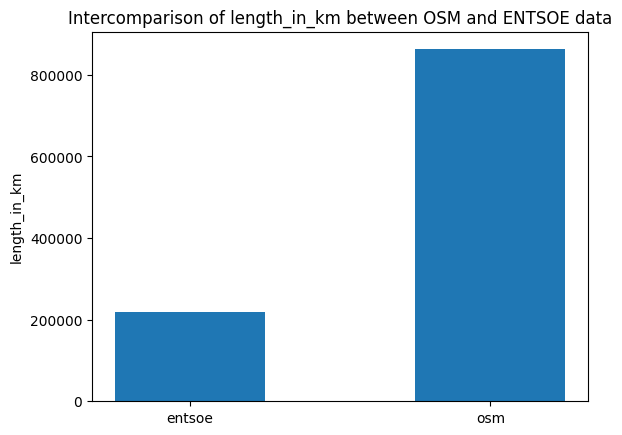

In [6]:
# Create a bar
plt.bar(['entsoe', 'osm'], [entsoe_df.length.sum(), osm_df.length.sum()], 0.5)
plt.title("Intercomparison of length_in_km between OSM and ENTSOE data")
plt.xlabel('')
plt.ylabel('length_in_km')
plt.show()


### Intercomparison by country

In [7]:
osm_country = osm_df.groupby(['country'])['length'].sum().reset_index()
entsoe_country = entsoe_df.groupby(['country'])['length'].sum().reset_index()


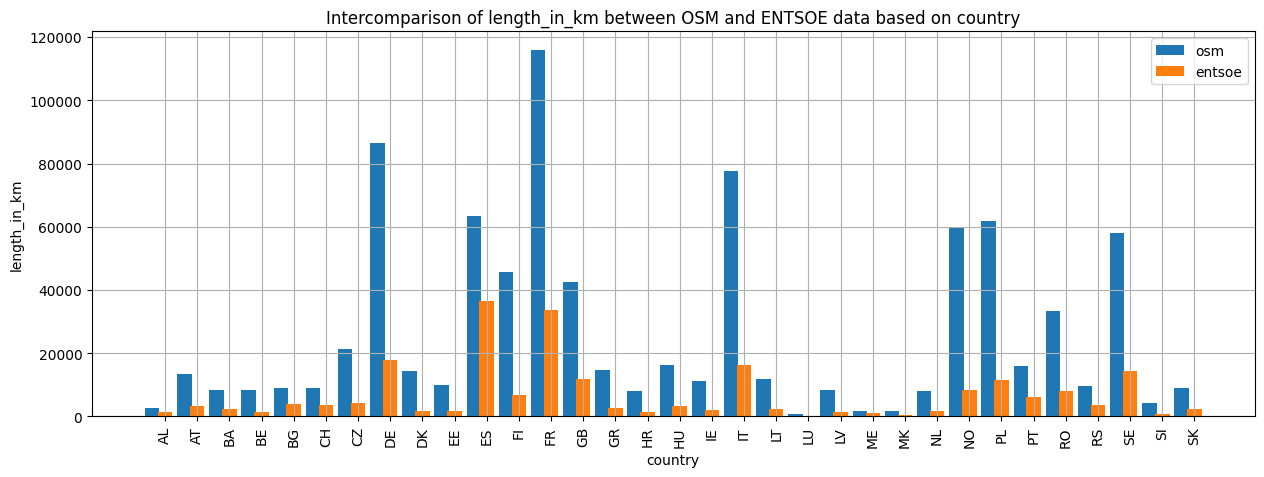

In [8]:
plt.figure(figsize=(15, 5))
osm_x_axis = np.arange(len(osm_country.country))
entsoe_x_axis = np.arange(len(entsoe_country.country))

plt.bar(osm_x_axis - 0.4, osm_country.length, 0.45, label='osm')
plt.bar(entsoe_x_axis, entsoe_country.length, 0.45, label='entsoe')
plt.xticks(osm_x_axis, osm_country.country)
plt.xticks(rotation=90)
plt.title(
    'Intercomparison of length_in_km between OSM and ENTSOE data based on country')
plt.xlabel('country')
plt.ylabel('length_in_km')
plt.grid(True)
plt.legend()
plt.show()


### Intercomparison by voltage levels

In [9]:
osm_voltage = osm_df.groupby(['v_nom'])['length'].sum().reset_index()
entsoe_voltage = entsoe_df.groupby(['v_nom'])['length'].sum().reset_index()


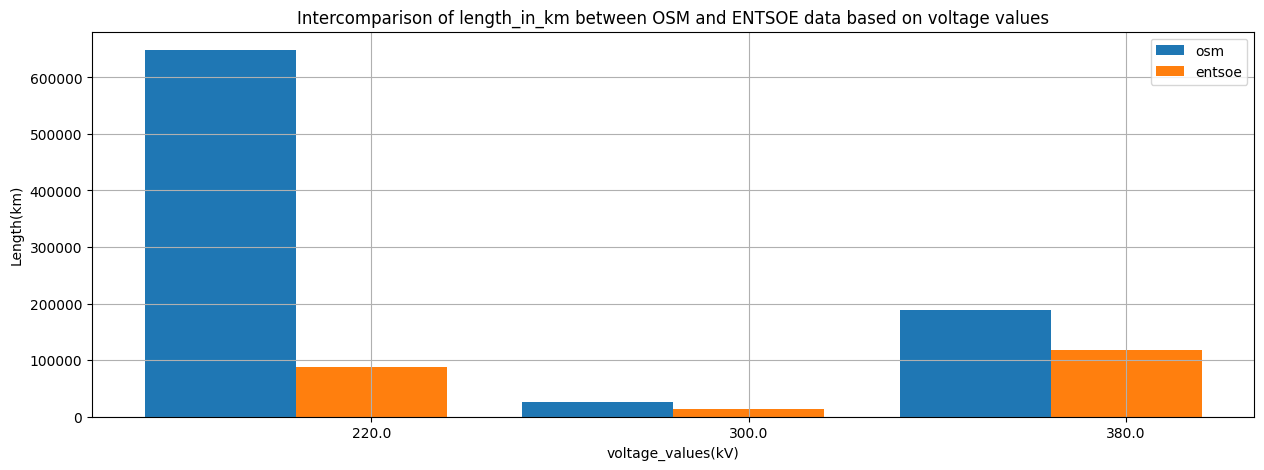

In [10]:
plt.figure(figsize=(15, 5))
osm_x_axis = np.arange(len(osm_voltage.v_nom))
entsoe_x_axis = np.arange(len(entsoe_voltage.v_nom))

plt.bar(osm_x_axis - 0.4, osm_voltage.length, 0.4, label='osm')
plt.bar(entsoe_x_axis, entsoe_voltage.length, 0.4, label='entsoe')
plt.xticks(osm_x_axis, osm_voltage.v_nom)
plt.xticks(rotation=0)
plt.title('Intercomparison of length_in_km between OSM and ENTSOE data based on voltage values')
plt.xlabel('voltage_values(kV)')
plt.ylabel('Length(km)')
plt.grid('True')
plt.legend()
plt.show()


# Conclusion

In light of the comparison presented above, it is evident that a notable discrepancy, approximately threefold, exists between the data obtained from OpenStreetMap (OSM) and the European Network of Transmission System Operators for Electricity (ENTSOE). This difference in data sources raises important questions about the underlying causes, which warrants further investigation.

To tackle this concern, we can explore an alternative approach by creating [a dedicated notebook](https://github.com/pypsa-meets-earth/documentation/pull/67) for in-depth network analysis, with a specific focus on the base network files related to Austria (AT) and North Macedonia (MK). The findings derived from this examination have the potential to provide valuable insights into the underlying factors that contribute to the disparities observed between OSM and ENTSOE data.
